In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import pickle

2023-03-21 00:32:44.474850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 00:32:44.977506: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2023-03-21 00:32:44.977542: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/include:/usr/local/cuda-11.0/lib64:
2023-03-21 00:32

# The Model

We decided to use the VGG19 model trained on imagenet.

In [2]:
DATA_DIR = "data/ILSVRC2012_img_val"
GROUND_TRUTH = "data/ground_truth.txt"
PICKLE_DIR = "pickles"
file_names = os.listdir(DATA_DIR)
READ_FROM_PICKLE = True
file_names.sort()

In [3]:
def read_images(file_names, data_dir):
    images = []
    i = 0
    for file_name in file_names:
        i += 1
        if i % 1000 == 0:
            print("Read {} images".format(i))
        file_path = os.path.join(data_dir, file_name)
        image = Image.open(file_path)
        image = image.resize((224, 224))
        image = np.array(image)
        images.append(image)
    return images

if not READ_FROM_PICKLE:
    images = read_images(file_names, DATA_DIR)
    for i in range(len(images)):
        # make sure each image has 3 channels
        if len(images[i].shape) != 3:
            images[i] = np.stack((images[i],)*3, axis=-1)
        if images[i].shape[2] == 4:
            images[i] = images[i][:,:,:3]
    images = np.array(images)
    with open(os.path.join(PICKLE_DIR, "images.pickle"), "wb") as f:
        pickle.dump(images, f)
else:
    with open(os.path.join(PICKLE_DIR, "images.pickle"), "rb") as f:
        images = pickle.load(f)

In [4]:
images.shape

(50000, 224, 224, 3)

In [15]:
labels = pd.read_csv(GROUND_TRUTH, sep=" ", header=None).to_numpy()

In [8]:
vgg_model = tf.keras.applications.VGG19(weights='imagenet', input_shape=(224, 224, 3))


# make all layers except the last one non-trainable
for layer in vgg_model.layers[:-1]:
    layer.trainable = False


In [9]:
# get classes from model:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
vgg_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# use cpu:

# make labels one-hot encoded

labels = tf.keras.utils.to_categorical(labels.reshape(-1), num_classes=1000)



with tf.device('/cpu:0'):
    vgg_model.fit(images, labels, epochs=1, batch_size=1)

IndexError: index 1000 is out of bounds for axis 1 with size 1000

array([490, 361, 171, ..., 128, 848, 186])

## Classify a couple examples:

In [8]:
y_hat = vgg_model.predict(images[:1000])

2023-03-21 00:08:15.524165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-21 00:08:15.953789: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-03-21 00:08:15.954676: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-03-21 00:08:15.954688: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-03-21 00:08:15.954740: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

 3/32 [=>............................] - ETA: 1s  

2023-03-21 00:08:22.741312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


32/32 [==============================] - 14s 194ms/step


In [9]:
# arg_max 
y_hat = np.argmax(y_hat, axis=1)

In [14]:
y_hat

array([ 65, 795, 160, 470, 431,  65, 334, 999, 532, 332, 109, 286, 370,
       757, 840, 147, 552,  21, 526, 517, 334, 173, 679, 727,  86, 526,
       270, 208,  64, 448, 324, 573, 150, 421, 586, 887, 113, 398, 529,
       307, 431, 713, 129, 198, 222, 846, 565, 246, 817, 697,  21,  29,
       844, 591, 333, 468, 157, 356, 840, 446, 735, 209, 107,  46, 522,
       390, 101, 591, 870, 903,   6,   3,  21, 476,  80, 415, 178, 246,
       170, 461, 970, 160, 788,  17, 882, 498, 376,  58, 487,  50, 222,
       382, 366, 484, 373, 872, 330, 142, 956, 349, 473, 178, 872, 810,
       552, 906,  70, 889, 632, 655, 887, 648, 227, 845, 876, 959, 516,
       646, 480, 645, 449, 483, 714, 529, 309, 752, 352,  21, 934, 283,
       802, 526, 276, 168, 526, 104, 772, 328, 969, 212, 178, 328, 771,
       896, 977, 971, 267, 745, 590, 978, 624, 637,  39, 115, 108, 272,
       279, 763, 765, 646, 205, 894, 438, 504, 937, 687, 781, 666, 583,
       158, 825, 212, 659, 257, 436, 199, 142, 250, 203, 231, 61

In [15]:
# indecies of labels where label = 1:
indeces = np.where(labels == 23)[0]

In [16]:
indeces

array([ 2027,  2306,  2453,  5148,  5293,  5620,  7869,  8478, 12257,
       14436, 14832, 15698, 16648, 22123, 22235, 23993, 24373, 25531,
       26105, 27303, 27994, 28457, 29077, 29497, 29733, 29821, 30315,
       30623, 31890, 33046, 34451, 35242, 36870, 37446, 39408, 40697,
       41086, 41632, 43520, 46149, 46174, 46218, 46402, 48095, 48216,
       48717, 49512, 49544, 49779, 49991])

In [24]:
# create a numpy array of the indeceis of the images that are of class 23:
indeces = np.where(labels == 490)[0]

# get the images that are of class 23:
images_23 = images[indeces]

In [25]:
images_23.shape

(50, 224, 224, 3)

In [26]:
y_hat = vgg_model.predict(images_23)

# y_hat = np.argmax(y_hat, axis=1)

2023-03-21 00:52:08.185513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-21 00:52:08.605124: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-03-21 00:52:08.605882: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-03-21 00:52:08.605889: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-03-21 00:52:08.605918: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

1/2 [==============>...............] - ETA: 7s

2023-03-21 00:52:15.497964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2/2 [==============================] - 12s 5s/step


In [19]:
y_hat[0]

array([4.08049573e-06, 1.39582619e-06, 5.39132679e-06, 5.26597723e-05,
       8.17847904e-04, 2.40933237e-04, 1.55963795e-03, 4.07961625e-06,
       4.32922121e-07, 2.11239574e-04, 2.39513292e-06, 6.49916672e-07,
       9.32556702e-07, 1.14248296e-05, 8.80197149e-07, 1.71315651e-06,
       2.51105962e-06, 8.02282045e-07, 1.89297225e-06, 9.62175818e-07,
       3.56643091e-06, 5.40468045e-06, 6.03617991e-06, 3.32983473e-06,
       5.95494555e-07, 3.49840229e-05, 3.20794265e-04, 7.18044685e-05,
       4.05569517e-05, 6.92980393e-05, 1.51267901e-04, 2.67412065e-06,
       6.28409398e-05, 1.87684281e-03, 7.42064673e-04, 2.46094278e-05,
       5.56699488e-05, 1.22243900e-05, 7.89894024e-04, 1.06633146e-04,
       1.56264232e-05, 7.86623568e-04, 3.55598277e-05, 6.74992916e-05,
       6.01565873e-04, 1.75298046e-04, 4.30785076e-05, 9.27307556e-05,
       1.16038986e-03, 3.88577208e-03, 3.70594906e-04, 8.62703109e-06,
       1.96443629e-02, 2.68520936e-02, 2.82011610e-02, 3.38141137e-04,
      

In [27]:
tf.keras.applications.vgg19.decode_predictions(y_hat, top=1)

35363/35363 [==============================] - 0s 0us/step


[[('n01751748', 'sea_snake', 0.47672382)],
 [('n01751748', 'sea_snake', 0.78579056)],
 [('n01751748', 'sea_snake', 0.98491466)],
 [('n01751748', 'sea_snake', 0.62539023)],
 [('n01751748', 'sea_snake', 0.6275712)],
 [('n01751748', 'sea_snake', 0.4979992)],
 [('n01737021', 'water_snake', 0.67158806)],
 [('n09256479', 'coral_reef', 0.26914987)],
 [('n01751748', 'sea_snake', 0.97943753)],
 [('n01950731', 'sea_slug', 0.9578252)],
 [('n01751748', 'sea_snake', 0.2198501)],
 [('n01751748', 'sea_snake', 0.7796114)],
 [('n02641379', 'gar', 0.271905)],
 [('n01751748', 'sea_snake', 0.9725391)],
 [('n02869837', 'bonnet', 0.11049271)],
 [('n01494475', 'hammerhead', 0.17553638)],
 [('n15075141', 'toilet_tissue', 0.23398037)],
 [('n02276258', 'admiral', 0.21024698)],
 [('n01751748', 'sea_snake', 0.7825636)],
 [('n01751748', 'sea_snake', 0.6292295)],
 [('n09256479', 'coral_reef', 0.47323078)],
 [('n01751748', 'sea_snake', 0.94948965)],
 [('n01751748', 'sea_snake', 0.9619373)],
 [('n01737021', 'water_sn

In [16]:
y_hat

array([ 65,  65,  65,  65,  65,  65,  58, 973,  65, 115,  65,  65, 395,
        65, 452,   4, 999, 321,  65,  65, 973,  65,  65,  58,  65,  65,
        58,  34,  65, 973,  65,  65,  65, 111,  58, 110,  58,  65,  55,
       390, 110, 549,  65,  65, 600,  65,  25,  65,  65, 110])

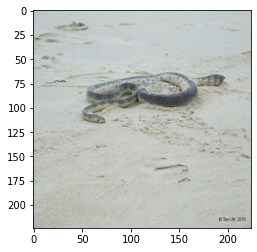

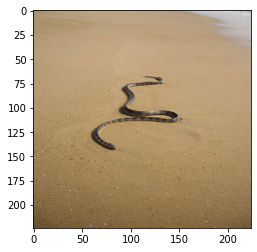

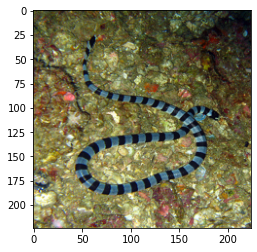

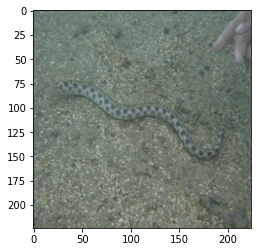

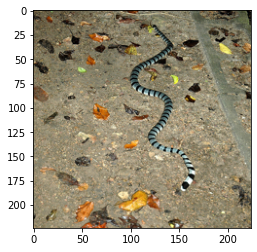

In [17]:
# plot images where label = 1:
for i in indeces[:5]:
    plt.imshow(images[i])
    plt.show()